In [1]:
import matplotlib.pyplot as plt
import numpy as np
from constraint import ConstraintBEMG,ConstraintGauss,RegArray,FunGauss,FunBEMG,FunLin
from pymcr.constraints import ConstraintNonneg, ConstraintNorm
from sklearn.decomposition import FastICA,NMF
from pymcr.mcr import McrAR
import logging
import sys

#pyMCRの詳細ログを出すための設定
logger = logging.getLogger('pymcr')
logger.setLevel(logging.DEBUG)
stdout_handler = logging.StreamHandler(stream=sys.stdout)
stdout_format = logging.Formatter('%(message)s')  # Just a basic message akin to print statements
stdout_handler.setFormatter(stdout_format)
logger.addHandler(stdout_handler)


# シミュレーションデータ作成


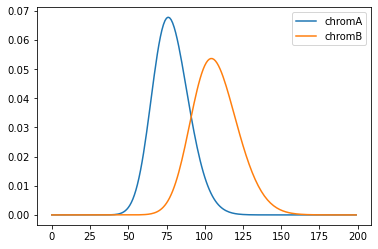

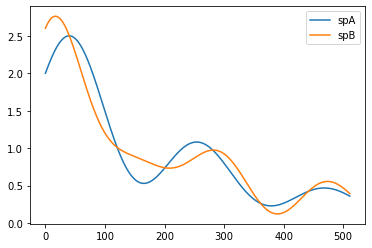

In [2]:
from sim_chrom import SimChrom,IsoRP,IsoGLang,IsoBET,IsoLang
import matplotlib.pyplot as plt
import numpy as np 

#Make simulalated chromatgarm

inject=1
if True:
    Ws=3.0
    rt=1.0 
    def make_chrom(Ws,rt):
        a=rt/Ws
        iso=IsoLang(a,Ws)

        chrom=SimChrom(100,iso,dead_volume=0,pass_rate=0,inject=inject)
        chrom=np.array([ chrom.step() for i in range(200)])
        return chrom
    chromA=make_chrom(Ws,rt-0.2)
    chromB=make_chrom(Ws,rt+0.1)
else:
    x=np.linspace(-6,6,200)
    chromA=np.exp(-(x-1)**2)
    chromB=np.exp(-(x+1)**2)
c=np.linspace(0,1,100)

plt.figure()
plt.plot(chromA,label="chromA")
plt.plot(chromB,label="chromB")
plt.legend()
plt.show()

#Make dummpy spectrum
x=np.linspace(0,1,512)
spA=np.exp(-2*x)*(2+np.sin(x*15))
spB=spA+ np.exp(-2*x)*(np.cos(x*20)*0.6)

#save simulated chromagram for pyMCR's D
dA=chromA.reshape(-1,1)*spA.reshape(1,-1)
dB=chromB.reshape(-1,1)*spB.reshape(1,-1)




plt.figure()
plt.plot(spA,label="spA")
plt.plot(spB,label="spB")
plt.legend()
plt.show()

D=dA+dB +  np.random.randn(*dA.shape)*0.001
gA=np.sum(dA,axis=1)#Grand Truth
gB=np.sum(dB,axis=1)#Grand Truth
gsA=np.sum(dA,axis=0)#Grand Truth
gsB=np.sum(dB,axis=0)#Grand Truth

# 初期値を作成
pyMCRは何らかの初期値が必要なので、FastICAやNMFを使って、クロマト形状の初期値を作る。

ショルダーピークが見えてれば人間が目視でガウス関数置て初期値をつくってあげるほうが確実。

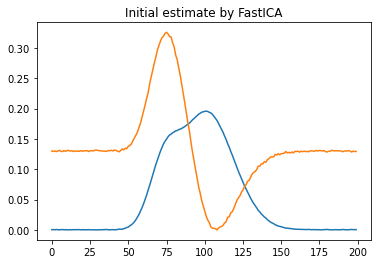

In [3]:
ica=FastICA(n_components=2)
#ica=NMF(n_components=2)
DN=np.copy(D)
DN[DN<1e-100]=1e-100
C_est=ica.fit_transform(DN)
#flip negative peak
C_est[:,np.max(C_est,axis=0)  < -1*np.min(C_est,axis=0)]*=-1
#remove base line
C_est -= np.min(C_est,axis=0)

plt.figure()
plt.title("Initial estimate by FastICA")
plt.plot(C_est)
plt.show()

# 素のMCRのデモ
MCRは以下の関係を解く問題 行列Cは成分毎のクロマト、STには各正文のスペクトルが入って。成分数がk、保持時間がN、スペクトルがm次元だとすると、C.shape=(N,k),ST.shape(k,M)となる行列になっている。Dは(M,N)の観測行列、すなわちLC-PDAの3次元データ。
$$
D=C \cdot ST
$$

素のMCRは以下の２つ処理を使ってC,STを交互に最適化します。このときに使うのがOLS(最小二乗法）もしくはNNLS(C,STを非負に制約した最小二乗法)。
$$
\hat{C}=argmin_{C} | D- C \cdot ST |
$$
$$
\hat{ST}=argmin_{ST} | D- C \cdot ST |
$$
$ | D- C \cdot ST | $で示される誤差エネルギー(mse)が減らなくなるまで実行します。


Iter: 1 (ST)	mse: 3.5114e-05
Iter: 2 (C)	mse: 1.9875e-06
Iter: 2 (ST)	mse: 1.3389e-06
Iter: 3 (C)	mse: 1.1604e-06
Iter: 3 (ST)	mse: 1.0862e-06
Iter: 4 (C)	mse: 1.0557e-06
Iter: 4 (ST)	mse: 1.0405e-06
Iter: 5 (C)	mse: 1.0322e-06
Iter: 5 (ST)	mse: 1.0268e-06
Iter: 6 (C)	mse: 1.0230e-06
Iter: 6 (ST)	mse: 1.0200e-06
Iter: 7 (C)	mse: 1.0176e-06
Iter: 7 (ST)	mse: 1.0155e-06
Iter: 8 (C)	mse: 1.0135e-06
Iter: 8 (ST)	mse: 1.0118e-06
Iter: 9 (C)	mse: 1.0102e-06
Iter: 9 (ST)	mse: 1.0086e-06
Iter: 10 (C)	mse: 1.0072e-06
Iter: 10 (ST)	mse: 1.0059e-06
Iter: 11 (C)	mse: 1.0046e-06
Iter: 11 (ST)	mse: 1.0035e-06
Iter: 12 (C)	mse: 1.0023e-06
Iter: 12 (ST)	mse: 1.0013e-06
Iter: 13 (C)	mse: 1.0003e-06
Iter: 13 (ST)	mse: 9.9934e-07
Iter: 14 (C)	mse: 9.9844e-07
Iter: 14 (ST)	mse: 9.9760e-07
Iter: 15 (C)	mse: 9.9680e-07
Iter: 15 (ST)	mse: 9.9605e-07
Iter: 16 (C)	mse: 9.9534e-07
Iter: 16 (ST)	mse: 9.9466e-07
Iter: 17 (C)	mse: 9.9402e-07
Iter: 17 (ST)	mse: 9.9341e-07
Iter: 18 (C)	mse: 9.9283e-07
Iter: 18 (ST)	

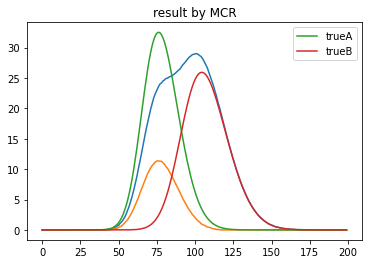

In [4]:
mcrar = McrAR(c_regr='NNLS', st_regr='NNLS',c_constraints=[ConstraintNonneg()])
mcrar.fit(D, C=C_est,verbose=True)

plt.figure()
plt.title("result by MCR")
plt.plot(mcrar.C_opt_  * np.sum(mcrar.ST_opt_,axis=1)  )
plt.plot(gA,label="trueA")
plt.plot(gB,label="trueB")
plt.legend()
plt.show()

# BEMG Constraintを使う
pyMCRのConstraint機構をつかった例です

Cの最適化STの最適化の間にBEMG制約を挟みます

$$
\hat{C}=argmin_{C} | D- C \cdot ST |
$$
$$
\hat{\theta}=argmin_{\theta} | C- BEMG(\theta) | \\
C=BEMG{\hat{\theta}}
$$
$$
\hat{ST}=argmin_{ST} | D- C \cdot ST |
$$

BEMG回帰や素のMCRでは各ステップで誤差$ |D -C \dot ST | $　を小さくするが、ConstraintはこのDに関する誤差以外のものを最適化しており、
このステップで逆に誤差が増える場合がる。このためtol_increaseに大きな値を設定し、誤差が増えてもループを回す様に設定している。
誤差が最小になってから(tol_n_increase)回だけループを回すようになる。

最適化ループ終了後の値がmcrar_c.C_ or ST_に入り、C_opt_ ST_opt_に途中にあった最小誤差の値が入る。


Iter: 1 (ST)	mse: 3.5114e-05
Iter: 2 (C)	mse: 1.6884e-05
Iter: 2 (ST)	mse: 7.7323e-06
Iter: 3 (C)	mse: 9.3195e-06
Iter: 3 (ST)	mse: 7.0843e-06
Iter: 4 (C)	mse: 8.2620e-06
Iter: 4 (ST)	mse: 7.4723e-06
Iter: 5 (C)	mse: 7.4943e-06
Iter: 5 (ST)	mse: 6.9904e-06
Iter: 6 (C)	mse: 6.7872e-06
Iter: 6 (ST)	mse: 6.3745e-06
Iter: 7 (C)	mse: 6.1380e-06
Iter: 7 (ST)	mse: 5.7695e-06
Iter: 8 (C)	mse: 5.5311e-06
Iter: 8 (ST)	mse: 5.1934e-06
Iter: 9 (C)	mse: 4.9640e-06
Iter: 9 (ST)	mse: 4.6563e-06
Iter: 10 (C)	mse: 4.4436e-06
Iter: 10 (ST)	mse: 4.1694e-06
Iter: 11 (C)	mse: 3.9790e-06
Iter: 11 (ST)	mse: 3.7421e-06
Iter: 12 (C)	mse: 3.5777e-06
Iter: 12 (ST)	mse: 3.3789e-06
Iter: 13 (C)	mse: 3.2409e-06
Iter: 13 (ST)	mse: 3.0784e-06
Iter: 14 (C)	mse: 2.9649e-06
Iter: 14 (ST)	mse: 2.8344e-06
Iter: 15 (C)	mse: 2.7421e-06
Iter: 15 (ST)	mse: 2.6385e-06
Iter: 16 (C)	mse: 2.5637e-06
Iter: 16 (ST)	mse: 2.4818e-06
Iter: 17 (C)	mse: 2.4210e-06
Iter: 17 (ST)	mse: 2.3562e-06
Iter: 18 (C)	mse: 2.3064e-06
Iter: 18 (ST)	

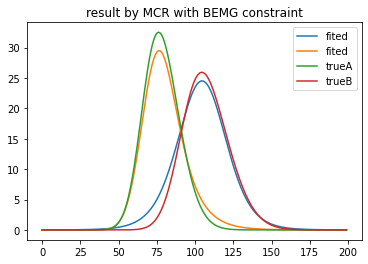

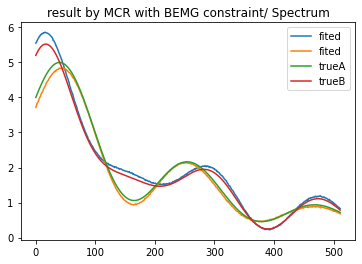

In [5]:
#Constrintを使うほうが処理が早いが、収束が保証されないので一旦誤差量が上がる
mcrar_c = McrAR(c_regr='OLS', st_regr='OLS',st_constraints=[],c_constraints=[ConstraintBEMG(range(2)) ],tol_increase=100)
#C_est_c=ConstraintBEMG(range(2)).transform(C_est)
mcrar_c.fit(D, C=C_est,verbose=True)

plt.figure()
plt.title("result by MCR with BEMG constraint")
print(np.sum(mcrar.ST_opt_,axis=1).shape)

plt.plot(mcrar_c.C_opt_* np.sum(mcrar_c.ST_opt_,axis=1).reshape(1,-1),label="fited")
plt.plot(gA,label="trueA")
plt.plot(gB,label="trueB")
plt.legend()
plt.show()

plt.figure()
plt.title("result by MCR with BEMG constraint/ Spectrum")
plt.plot(mcrar_c.ST_opt_.transpose()* np.sum(mcrar_c.C_opt_,axis=0),label="fited")
plt.plot(gsA,label="trueA")
plt.plot(gsB,label="trueB")
plt.legend()
plt.show()


# BEMG回帰を行う

素のMCRの以下の部分をBEMG関数に買えます
$$
\hat{C}=argmin_{C} | D- C \cdot ST |
$$
ぐたいてきにはBEMGのパラメータ（高さ・中心・幅・テーリング度合いa,b)の5つのパラメータ$ \theta $を最適化してCを求めます
$$
\hat{\theta}=argmin_{\theta} | D- C \cdot BEMG(\theta) | \\
C=BEMG(\hat{\theta})
$$

そこが入れ替わるだけで、シンプルなものですが、成分数の5倍の数だけパラメータがあるし、一旦Dの次元まで展開する愚直でとっても重い実装例になっています。
（普通はSVDなりで次元縮約する）


Iter: 1 (ST)	mse: 3.5114e-05
Iter: 2 (C)	mse: 5.3100e-06
Iter: 2 (ST)	mse: 3.7402e-06
Iter: 3 (C)	mse: 2.7854e-06
Iter: 3 (ST)	mse: 2.3376e-06
Iter: 4 (C)	mse: 2.0287e-06
Iter: 4 (ST)	mse: 1.8458e-06
Iter: 5 (C)	mse: 1.7070e-06
Iter: 5 (ST)	mse: 1.6110e-06
Iter: 6 (C)	mse: 1.5334e-06
Iter: 6 (ST)	mse: 1.4745e-06
Iter: 7 (C)	mse: 1.4251e-06
Iter: 7 (ST)	mse: 1.3854e-06
Iter: 8 (C)	mse: 1.3514e-06
Iter: 8 (ST)	mse: 1.3231e-06
Iter: 9 (C)	mse: 1.2985e-06
Iter: 9 (ST)	mse: 1.2776e-06
Iter: 10 (C)	mse: 1.2592e-06
Iter: 10 (ST)	mse: 1.2433e-06
Iter: 11 (C)	mse: 1.2291e-06
Iter: 11 (ST)	mse: 1.2166e-06
Iter: 12 (C)	mse: 1.2055e-06
Iter: 12 (ST)	mse: 1.1956e-06
Iter: 13 (C)	mse: 1.1866e-06
Iter: 13 (ST)	mse: 1.1785e-06
Iter: 14 (C)	mse: 1.1712e-06
Iter: 14 (ST)	mse: 1.1645e-06
Iter: 15 (C)	mse: 1.1584e-06
Iter: 15 (ST)	mse: 1.1528e-06
Iter: 16 (C)	mse: 1.1476e-06
Iter: 16 (ST)	mse: 1.1427e-06
Iter: 17 (C)	mse: 1.1382e-06
Iter: 17 (ST)	mse: 1.1340e-06
Iter: 18 (C)	mse: 1.1301e-06
Iter: 18 (ST)	

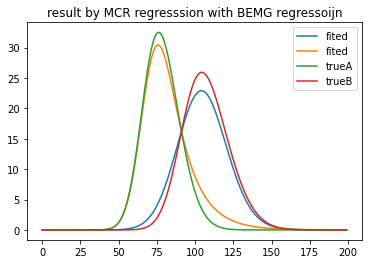

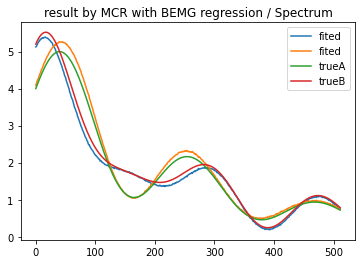

In [6]:
    #BEMG関数制約にregressorを使う
    #処理がとっても重いが、収束はする　　しかし、最適解にいくとは限らない
    c_regr=RegArray([FunBEMG(),FunBEMG()])
    mcrar_c = McrAR(c_regr=c_regr, st_regr='NNLS',st_constraints=[],c_constraints=[],tol_increase=100)
    #C_est_c=ConstraintBEMG(range(2)).transform(C_est)
    mcrar_c.fit(D, C=C_est,verbose=True)

    plt.figure()
    plt.title("result by MCR regresssion with BEMG regressoijn")
    print(np.sum(mcrar.ST_opt_,axis=1).shape)

    plt.plot(mcrar_c.C_opt_* np.sum(mcrar_c.ST_opt_,axis=1).reshape(1,-1),label="fited")
    plt.plot(gA,label="trueA")
    plt.plot(gB,label="trueB")
    plt.legend()
    plt.show()

    plt.figure()
    plt.title("result by MCR with BEMG regression / Spectrum")
    plt.plot(mcrar_c.ST_opt_.transpose()* np.sum(mcrar_c.C_opt_,axis=0),label="fited")
    plt.plot(gsA,label="trueA")
    plt.plot(gsB,label="trueB")
    plt.legend()
    plt.show()

# Gauss Constraintの例

Iter: 1 (ST)	mse: 3.5114e-05
Iter: 2 (C)	mse: 1.1595e-05
Iter: 2 (ST)	mse: 8.7909e-06
Iter: 3 (C)	mse: 1.0399e-05
Iter: 3 (ST)	mse: 9.2771e-06
Iter: 4 (C)	mse: 9.8849e-06
Iter: 4 (ST)	mse: 9.2878e-06
Iter: 5 (C)	mse: 9.4113e-06
Iter: 5 (ST)	mse: 9.0506e-06
Iter: 6 (C)	mse: 8.9843e-06
Iter: 6 (ST)	mse: 8.7457e-06
Iter: 7 (C)	mse: 8.6129e-06
Iter: 7 (ST)	mse: 8.4418e-06
Iter: 8 (C)	mse: 8.2947e-06
Iter: 8 (ST)	mse: 8.1643e-06
Iter: 9 (C)	mse: 8.0228e-06
Iter: 9 (ST)	mse: 7.9185e-06
Iter: 10 (C)	mse: 7.7889e-06
Iter: 10 (ST)	mse: 7.7021e-06
Iter: 11 (C)	mse: 7.5850e-06
Iter: 11 (ST)	mse: 7.5105e-06
Iter: 12 (C)	mse: 7.4046e-06
Iter: 12 (ST)	mse: 7.3389e-06
Iter: 13 (C)	mse: 7.2423e-06
Iter: 13 (ST)	mse: 7.1828e-06
Iter: 14 (C)	mse: 7.0937e-06
Iter: 14 (ST)	mse: 7.0388e-06
Iter: 15 (C)	mse: 6.9555e-06
Iter: 15 (ST)	mse: 6.9038e-06
Iter: 16 (C)	mse: 6.8249e-06
Iter: 16 (ST)	mse: 6.7755e-06
Iter: 17 (C)	mse: 6.6998e-06
Iter: 17 (ST)	mse: 6.6518e-06
Iter: 18 (C)	mse: 6.5784e-06
Iter: 18 (ST)	

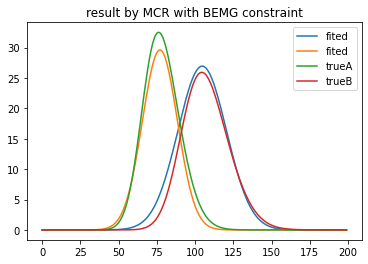

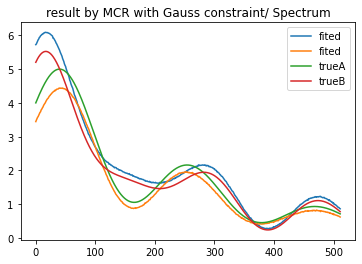

In [7]:
mcrar_c = McrAR(c_regr='NNLS', st_regr='NNLS',st_constraints=[],c_constraints=[ConstraintGauss(range(2)) ],tol_increase=100)
#C_est_c=ConstraintBEMG(range(2)).transform(C_est)
mcrar_c.fit(D, C=C_est,verbose=True)

plt.figure()
plt.title("result by MCR with BEMG constraint")
print(np.sum(mcrar.ST_opt_,axis=1).shape)

plt.plot(mcrar_c.C_opt_* np.sum(mcrar_c.ST_opt_,axis=1).reshape(1,-1),label="fited")
plt.plot(gA,label="trueA")
plt.plot(gB,label="trueB")
plt.legend()
plt.show()

plt.figure()
plt.title("result by MCR with Gauss constraint/ Spectrum")
plt.plot(mcrar_c.ST_opt_.transpose()* np.sum(mcrar_c.C_opt_,axis=0),label="fited")
plt.plot(gsA,label="trueA")
plt.plot(gsB,label="trueB")
plt.legend()
plt.show()


In [8]:
# Gauss Regressionの例

In [ ]:
c_regr=RegArray([FunGauss(),FunGauss()])
mcrar_c = McrAR(c_regr=c_regr, st_regr='NNLS',st_constraints=[],c_constraints=[])
mcrar_c.fit(D, C=C_est,verbose=True)

plt.figure()
plt.title("result by MCR regresssion with Gauss regressoijn")
print(np.sum(mcrar.ST_opt_,axis=1).shape)

plt.plot(mcrar_c.C_opt_* np.sum(mcrar_c.ST_opt_,axis=1).reshape(1,-1),label="fited")
plt.plot(gA,label="trueA")
plt.plot(gB,label="trueB")
plt.legend()
plt.show()

plt.figure()
plt.title("result by MCR with Gauss regression / Spectrum")
plt.plot(mcrar_c.ST_opt_.transpose()* np.sum(mcrar_c.C_opt_,axis=0),label="fited")
plt.plot(gsA,label="trueA")
plt.plot(gsB,label="trueB")
plt.legend()
plt.show()

Iter: 1 (ST)	mse: 3.5114e-05
Iter: 2 (C)	mse: 5.3614e-06
Iter: 2 (ST)	mse: 3.7006e-06
Iter: 3 (C)	mse: 2.7676e-06
Iter: 3 (ST)	mse: 2.3514e-06
Iter: 4 (C)	mse: 2.0760e-06
Iter: 4 (ST)	mse: 1.9232e-06
Iter: 5 (C)	mse: 1.8171e-06
Iter: 5 (ST)	mse: 1.7518e-06
Iter: 6 (C)	mse: 1.7061e-06
Iter: 6 (ST)	mse: 1.6767e-06
